# Hepatitis dataset

In [79]:
#Importing the necessary libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We first need to implement the cost functions.

In [80]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))  

We also need to implement the greedy algorithm, which will optimize the structure of the tree such that the cost is as small as possible, as well as a function to evaluate the accuracy of the predictions. The cost functions and the greedy algorithm are implemented first so that the DecisionTree class will be able to use those functions. 

In [81]:
def greedy_test(node, cost_fn):
    #initialization
    best_cost = np.inf #doesn't need to be modified 
    best_feature, best_value = None, None
    node.data_indices = node.data_indices.astype(np.int32) #added this
    #print(isinstance(node.data, np.ndarray))
    if (isinstance(node.data, np.ndarray) == False):
        node.data = node.data.to_numpy() #added this 
    num_instances, num_features = node.data.shape #Only continuous features and instances 
    #sort the features
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2. #This will need to be there for only continuous features
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]: #could split based on whether we have a 1 or a 2 
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            if (isinstance(node.labels, np.ndarray) == False):
                node.labels = node.labels.to_numpy()
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

def evaluate_acc(y_pred, y_true):
    accuracy = np.sum(y_pred == y_true)/(y_true.shape[0])
    return accuracy

Now we can build the decision tree using the helper class Node and the class DecisionTree

In [82]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None #stores left child
        self.right = None
        self.split_feature = None #in case of non-leaf nodes 
        self.split_value = None #in case of non-leaf nodes 
        if parent:
            self.depth = parent.depth + 1 #obtaining the depth of this node
            self.data = parent.data
            self.labels = parent.labels #copies labels from the parent
            self.num_classes = parent.num_classes #copies number of classes from the parent. Here we have 2 (alive and dead)
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #counting the frequency of diff labels in the region defined by this node
            self.class_prob = class_prob/np.sum(class_prob) #class probability of this node
            #The class probabibities of the leaf nodes will be used to make predictions after we build the tree


class DecisionTree:
    def __init__(self, cost_fn, max_depth = 3, num_classes=None, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
        
    def fit(self, data, labels):
         pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test, max_depth):
         pass

Let's now implement the methods fit, fit_tree and predict 

In [83]:
def fit(self, data, labels, max_depth):
    self.data = data
    self.labels = labels
    self.max_depth = max_depth
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self                            #pass in python 3 means nothing happens and the method here is empty
        
def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right
    
DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree
       
def predict(self, data_test):
    if (isinstance(data_test, np.ndarray) == False):
                data_test = data_test.to_numpy()
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

We want to implement the KNN class

In [84]:
euclidean = lambda x1, x2: np.linalg.norm(x1-x2, axis=-1)

class KNN:
  def __init__(self, K=1, dist_fn=euclidean):
    self.dist_fn = dist_fn
    self.K = K
    return
  
  def fit(self, X, y, K):
    self.x = X
    self.y = y
    self.C = y.iloc[:, 0].nunique()
    self.K = K
    return self
  
  def predict(self, x_test):
    num_test = x_test.shape[0]
    distances = self.dist_fn(self.x.values[None, :, :], x_test.values[:, None, :])
    # print(distances)
    #ith-row of knns stores the indices of k closest training samples to the ith-test sample
    knns = np.zeros((num_test, self.K), dtype=int)
    #ith-row of y_prob has the probability distribution over C classes
    y_prob = np.zeros((num_test, self.C))
    # print(distances.shape)
    for i in range(num_test):
      knns[i,:] = np.argsort(distances[i])[:self.K]
      y_prob[i,:] = np.bincount(self.y.values[knns[i,:]][:,0], minlength=self.C)
    y_prob /= self.K
    return y_prob, knns

Let's now load the hepatitis data using a panda dataframe. For the analysis, we will only be using two features that have the highest correlation.

In [85]:
column_names = ['class', 'age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver big', 'liver firm', 'spleen palpable', 'spiders', 'ascites', 'varices', 'bilirubin', 'alk phosphate', 'sgot', 'albumin', 'protime', 'histology']
hep_df = pd.read_csv('hepatitis.csv', header=None, names = column_names)

#Clean the data
hep_df = hep_df[~hep_df.eq('?').any(1)]

hep_df = hep_df.astype({'steroid':'int64',
                        'fatigue':'int64',
                        'malaise':'int64',
                        'anorexia':'int64',
                        'liver big':'int64',
                        'liver firm':'int64',
                        'spleen palpable':'int64',
                        'spiders':'int64',
                        'ascites':'int64',
                        'varices':'int64',
                        'bilirubin':'float64',
                        'alk phosphate':'int64',
                        'sgot':'int64',
                        'albumin':'float64',
                        'protime':'int64'
                        })
hep_df.dtypes
#Randomize the data (just to make sure)
hep_df = hep_df.sample(frac=1, random_state=1).reset_index(drop=True)
hep_df

,class,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver big,liver firm,spleen palpable,spiders,ascites,varices,bilirubin,alk phosphate,sgot,albumin,protime,histology
0,2,20,1,1,2,1,1,1,2,2,2,1,1,2,1.0,160,118,2.9,23,2
1,2,56,1,1,2,1,2,2,2,2,2,2,2,2,0.7,71,18,4.4,100,1
2,2,44,1,2,2,2,2,2,2,2,2,2,2,2,0.6,110,145,4.4,70,1
3,2,54,1,2,2,2,2,2,2,2,2,2,2,2,1.0,85,30,4.5,0,2
4,2,30,1,1,2,2,2,2,2,2,2,2,2,2,0.7,100,31,4.0,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2,45,1,2,1,2,2,2,2,2,2,2,2,2,1.3,85,44,4.2,85,2
76,2,22,2,2,1,1,2,2,2,2,2,2,2,2,0.9,48,20,4.2,64,1
77,2,25,1,2,2,1,2,2,1,1,1,1,1,1,1.3,181,181,4.5,57,2
78,2,42,1,2,2,2,2,2,2,2,2,2,2,2,0.9,60,63,4.7,47,1


In [86]:
hep_df.describe()

,class,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver big,liver firm,spleen palpable,spiders,ascites,varices,bilirubin,alk phosphate,sgot,albumin,protime,histology
count,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000
mean,1.837500,40.66250,1.137500,1.525000,1.737500,1.350000,1.612500,1.850000,1.837500,1.525000,1.812500,1.687500,1.850000,1.875000,1.221250,102.912500,82.025000,3.843750,62.512500,1.41250
std,0.371236,11.28003,0.346547,0.502525,0.442769,0.479979,0.490253,0.359324,0.371236,0.502525,0.392775,0.466437,0.359324,0.332805,0.875213,53.684779,71.599974,0.576292,23.427774,0.49539
min,1.000000,20.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.300000,26.000000,14.000000,2.100000,0.000000,1.00000
25%,2.000000,32.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.700000,68.250000,30.750000,3.500000,46.000000,1.00000
50%,2.000000,38.50000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,85.000000,56.500000,4.000000,62.000000,1.00000
75%,2.000000,49.25000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.300000,133.500000,102.750000,4.200000,77.250000,2.00000
max,2.000000,72.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.800000,280.000000,420.000000,5.000000,100.000000,2.00000


Notable correlations:

Albumin/Ascites
Malaise/Fatigue, Malaise/Anorexia
Bilirubin/Varices
Ascites/Class
Histology/Class, Histology/Spiders, Histology/Ascites
Albumin/Class

In [87]:
hep_df.corr()

,class,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver big,liver firm,spleen palpable,spiders,ascites,varices,bilirubin,alk phosphate,sgot,albumin,protime,histology
class,1.000000,-0.212769,0.175876,0.123830,-0.108776,0.181151,0.275595,-0.185042,-0.194030,0.055978,0.135643,0.287839,0.479211,0.345785,-0.351557,-0.189360,0.078731,0.477404,0.395386,-0.456856
age,-0.212769,1.000000,-0.046265,0.016022,-0.043308,-0.111171,-0.074306,0.243440,-0.034422,-0.167090,-0.134460,-0.179086,-0.121954,-0.105793,0.160752,0.088183,-0.132269,-0.220464,-0.190169,0.310650
sex,0.175876,-0.046265,1.000000,0.016354,-0.091777,-0.064686,0.019558,-0.035579,-0.020908,-0.129018,0.005812,-0.122360,0.167729,0.041158,-0.114092,0.064612,0.016695,0.032880,-0.022822,-0.113365
steroid,0.123830,0.016022,0.016354,1.000000,0.058313,0.068224,0.168270,0.021031,0.191683,0.097744,-0.008016,-0.047253,0.021031,-0.132453,-0.086126,-0.028305,-0.001777,0.081408,0.069323,-0.118220
antivirals,-0.108776,-0.043308,-0.091777,0.058313,1.000000,-0.038716,-0.008018,-0.011934,0.122253,0.058313,-0.213811,-0.218352,-0.250622,-0.225494,0.200767,0.203513,0.141556,-0.252072,0.007032,0.211362
fatigue,0.181151,-0.111171,-0.064686,0.068224,-0.038716,1.000000,0.583660,0.308257,0.039072,0.225663,0.151074,0.325107,0.308257,0.118864,-0.289122,-0.155995,-0.199156,0.287159,0.255138,-0.135751
malaise,0.275595,-0.074306,0.019558,0.168270,-0.008018,0.583660,1.000000,0.528145,-0.002608,0.065510,0.012326,0.294075,0.312576,0.087280,-0.269677,-0.213404,-0.144686,0.275820,0.230215,-0.167436
anorexia,-0.185042,0.243440,-0.035579,0.021031,-0.011934,0.308257,0.528145,1.000000,0.194531,0.021031,0.067267,0.169932,0.019608,0.052926,-0.154764,-0.124711,-0.071686,-0.065713,0.036314,-0.003556
liver big,-0.194030,-0.034422,-0.020908,0.191683,0.122253,0.039072,-0.002608,0.194531,1.000000,0.463092,0.135643,0.068533,-0.090149,-0.064034,0.139327,-0.056615,0.058730,-0.149767,-0.089272,-0.043879
liver firm,0.055978,-0.167090,-0.129018,0.097744,0.058313,0.225663,0.065510,0.021031,0.463092,1.000000,0.184378,0.222765,0.021031,0.170297,-0.149444,-0.364257,-0.286035,0.251874,0.059646,-0.169067


Since the data might be imbalanced due to the ratio of the classes not being 40:40, we want to insure that each set will have the same ratio of dead and alive patients:

In [88]:
hep_df_X = hep_df[['albumin', 'protime']]
hep_df_y = hep_df['class']

#Balance the sets 
dead  = hep_df.loc[hep_df['class']==1]
alive = hep_df.loc[hep_df['class']==2]

dead_X = dead[['albumin', 'protime']]
alive_X = alive[['albumin', 'protime']]
dead_y = dead['class']
alive_y = alive['class']

#Separate the two sets in 2, then one half in 2 quarters. 
#The ratio of the elements in the sets will be as such: 50:25:25, for the test, training and validation sets respectively
n = dead.shape[0]
m = alive.shape[0]


#First the test set
test_X_dead = dead_X[:int(n/2)]
test_X_alive = alive_X[:int(m/2)]
hep_X_test = pd.concat([test_X_dead, test_X_alive], axis=0) #concat the rows 
#hep_X_test = hep_X_test.sample(frac=1, random_state=1).reset_index(drop=True) #randomize and reset indexing 

test_y_dead = dead_y[:int(n/2)]
test_y_alive = alive_y[:int(m/2)]
hep_y_test = pd.concat([test_y_dead, test_y_alive], axis=0) #concat the rows 
#hep_y_test = hep_y_test.sample(frac=1, random_state=1).reset_index(drop=True) #randomize and reset indexing 


#Then the training set
train_X_dead = dead_X[int(n/2):]
train_X_alive = alive_X[int(m/2):]
hep_X_train = pd.concat([train_X_dead, train_X_alive], axis=0) #concat the rows 

train_y_dead = dead_y[int(n/2):]
train_y_alive = alive_y[int(m/2):]
hep_y_train = pd.concat([train_y_dead, train_y_alive], axis=0) #concat the rows 

#We're halving the training set into 2 so that we can also have a validation set
a = train_X_dead.shape[0]
b = train_X_alive.shape[0]
#Storing the remaining data into an a dataframe so that we can divide again in half
train_X_d = dead_X[int(n/2):]
train_y_d = dead_y[int(n/2):]
train_X_a = alive_X[int(m/2):]
train_y_a = alive_y[int(m/2):]

#tr set:
tr_X_dead = train_X_d[int(a/2):]
tr_y_dead = train_y_d[int(a/2):]

tr_X_alive = train_X_a[int(b/2):]
tr_y_alive = train_y_a[int(b/2):]

hep_X_train_tr = pd.concat([tr_X_dead, tr_X_alive], axis=0) #concat the rows 
hep_y_train_tr = pd.concat([tr_y_dead, tr_y_alive], axis=0) #concat the rows 

#validation set:
va_X_dead = train_X_d[:int(a/2)]
va_y_dead = train_y_d[:int(a/2)]

va_X_alive = train_X_a[:int(b/2)]
va_y_alive = train_y_a[:int(b/2)]

hep_X_train_va = pd.concat([va_X_dead, va_X_alive], axis=0) #concat the rows 
hep_y_train_va = pd.concat([va_y_dead, va_y_alive], axis=0) #concat the rows 

We now want to determine the best depth for the decision tree using the validation set:

In [89]:
#Best depth
model_choices = []
train_acc = []
valid_acc = []

#Changing from panda dataframes to numpy arrays
hep_df_X = hep_df_X.to_numpy()
hep_df_y = hep_df_y.to_numpy()
hep_y_train_tr = hep_y_train_tr.to_numpy()
hep_X_train_va = hep_X_train_va.to_numpy()
hep_y_train_va = hep_y_train_va.to_numpy()
hep_X_train = hep_X_train.to_numpy()
hep_X_test = hep_X_test.to_numpy()
hep_y_train = hep_y_train.to_numpy()
hep_y_test = hep_y_test.to_numpy()

(num_instances, num_features), num_classes = hep_df_X.shape, np.max(hep_df_y)+1

for k in range(1, 11):
    hep_dt = DecisionTree(cost_fn = cost_gini_index)
    
    hep_y_train_tr_prob = hep_dt.fit(hep_X_train_tr, hep_y_train_tr, k).predict(hep_X_train_tr)
    hep_y_train_tr_pred = np.argmax(hep_y_train_tr_prob, axis=-1)
    acc_tr = evaluate_acc(hep_y_train_tr_pred, hep_y_train_tr)
    
    hep_y_train_va_prob = hep_dt.fit(hep_X_train_tr, hep_y_train_tr, k).predict(hep_X_train_va)
    hep_y_train_va_pred = np.argmax(hep_y_train_va_prob, axis=-1)
    acc_va = evaluate_acc(hep_y_train_va_pred, hep_y_train_va)

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)
    

#Find best k 
best_depth = model_choices[valid_acc.index(max(valid_acc))]   
hep_dt = DecisionTree(cost_fn = cost_gini_index)
hep_y_test_prob = hep_dt.fit(hep_X_train, hep_y_train, best_depth).predict(hep_X_test)
hep_y_test_pred = np.argmax(hep_y_test_prob, axis=-1)
test_accuracy = evaluate_acc(hep_y_test_pred, hep_y_test)
print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')

best depth = 1, test accuracy = 0.8205128205128205


We want to be able to visualize the effects of the depth on the acurracy of the prediction of the three sets using a plot:

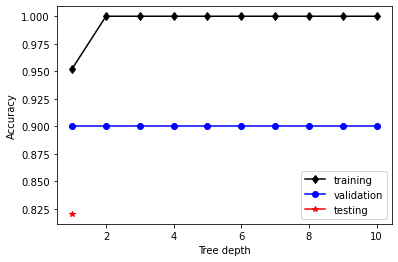

In [90]:
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Now we fit the tree to the training data and predict on the test data.

accuracy is 82.1.


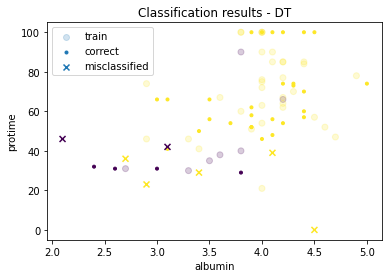

In [91]:
tree = DecisionTree(cost_fn = cost_gini_index)
probs_test = tree.fit(hep_X_train, hep_y_train, best_depth).predict(hep_X_test)
y_pred = np.argmax(probs_test,1)
accuracy = evaluate_acc(y_pred, hep_y_test)
print(f'accuracy is {accuracy*100:.1f}.')
#visualization
correct = hep_y_test == hep_y_test_pred 
incorrect = np.logical_not(correct)
plt.scatter(hep_X_train[:,0], hep_X_train[:,1], c=hep_y_train, marker='o', alpha=.2, label='train')
plt.scatter(hep_X_test[correct,0], hep_X_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(hep_X_test[incorrect,0], hep_X_test[incorrect,1], marker='x', c=hep_y_test[incorrect], label='misclassified')
plt.ylabel('protime')
plt.xlabel('albumin')
plt.title('Classification results - DT')
plt.legend()
plt.show()   

We also want to plot the decision boundary:

Text(0.5, 1.0, 'Depth = 1')

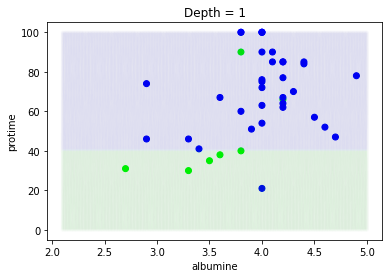

In [92]:
x0v = np.linspace(np.min(hep_df_X[:,0]), np.max(hep_df_X[:,0]), 200)
x1v = np.linspace(np.min(hep_df_X[:,1]), np.max(hep_df_X[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(cost_fn = cost_gini_index)
y_train_prob = np.zeros((hep_y_train.shape[0], num_classes))
y_train_prob[np.arange(hep_y_train.shape[0]), hep_y_train] = 1
y_prob_all = model.fit(hep_X_train, hep_y_train, best_depth).predict(x_all)
plt.scatter(hep_X_train[:,0], hep_X_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('protime')
plt.xlabel('albumine')
plt.title('Depth = ' + str(best_depth))


We want to see the effects of changing the cost function on the accuracy.

In [93]:
missclassification_tree = DecisionTree(cost_fn = cost_misclassification)
probs_test = missclassification_tree.fit(hep_X_train, hep_y_train, best_depth).predict(hep_X_test)
y_pred = np.argmax(probs_test,1)
m_accuracy = evaluate_acc(y_pred, hep_y_test)
print(f'accuracy using misclassification cost is {m_accuracy*100:.1f}.')

entropy_tree = DecisionTree(cost_fn = cost_entropy)
probs_test = entropy_tree.fit(hep_X_train, hep_y_train, best_depth).predict(hep_X_test)
y_pred = np.argmax(probs_test,1)
e_accuracy = evaluate_acc(y_pred, hep_y_test)
print(f'accuracy using entropy is {e_accuracy*100:.1f}.')

accuracy using misclassification cost is 82.1.
accuracy using entropy is 82.1.


We now want to visualize the tree using sklearn:

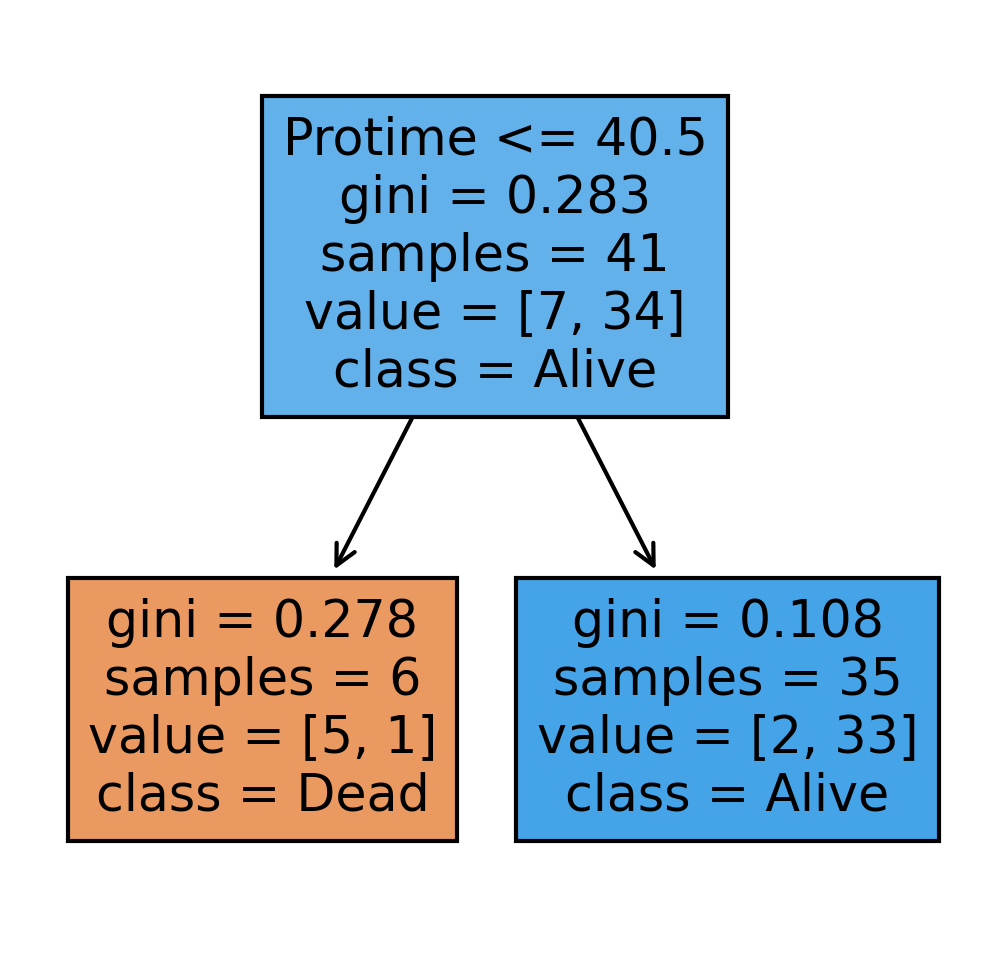

In [94]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
sktree = DecisionTreeClassifier(max_depth=best_depth, random_state=(0))
sktree.fit(hep_X_train, hep_y_train)
sktree.predict(hep_X_test)

fn = ['Albumine', 'Protime']
cn = ['Dead', "Alive"]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

tree.plot_tree(sktree, feature_names = fn, class_names=cn, filled = True)
fig.savefig('imagename.png')

Now we want to work with the KNN class. For that, the data needs to be standardized. We will thus redo the steps above so that the algorithm can run smoothly.

In [95]:
#standardize
hep_df_x = hep_df[['albumin', 'protime']]
hep_df_x = (hep_df_x - hep_df_x.mean())/hep_df_x.std()

#Divide the set in two: one contains all the entries with class c = 1 (dataframe called 'dead'), and the other one contains the ones with c = 2 (df called 'alive')
dead  = hep_df.loc[hep_df['class']==1] #Contains all the rows with class c = 1
alive = hep_df.loc[hep_df['class']==2] #Contains all the rows with class c = 2

dead_X = hep_df_x.loc[hep_df['class']==1]
alive_X = hep_df_x.loc[hep_df['class']==2]
dead_y = dead[['class']]
alive_y = alive[['class']]

#Separate the two sets in 2, then one half in 2 quarters. 
#The ratio of the elements in the sets will be as such: 50:25:25 for the test, training and validation sets respectively
n = dead.shape[0]
m = alive.shape[0]


#First the test set
test_X_dead = dead_X[:int(n/2)]
test_X_alive = alive_X[:int(m/2)]
hep_x_test = pd.concat([test_X_dead, test_X_alive], axis=0) #concat the rows 

test_y_dead = dead_y[:int(n/2)]
test_y_alive = alive_y[:int(m/2)]
hep_y_test = pd.concat([test_y_dead, test_y_alive], axis=0) #concat the rows 

#Then the training set
train_X_dead = dead_X[int(n/2):]
train_X_alive = alive_X[int(m/2):]
hep_x_train = pd.concat([train_X_dead, train_X_alive], axis=0) #concat the rows 

train_y_dead = dead_y[int(n/2):]
train_y_alive = alive_y[int(m/2):]
hep_y_train = pd.concat([train_y_dead, train_y_alive], axis=0) #concat the rows 

In [96]:
model = KNN()
y_prob, knns = model.fit(hep_x_train, hep_y_train - 1, K=1).predict(hep_x_test)
y_pred = np.argmax(y_prob, axis=-1)
y_pred = y_pred + 1
y_pred

array([1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [97]:
hep_y_test.values.flatten()

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [98]:
def evaluate_acc(y_true, y_pred):
  return np.sum(y_pred == y_true)/y_true.shape[0]

Use validation set and try all K between 1 and 11.

In [99]:
#We're halving the training set into 2 so that we can also have a validation set
a = train_X_dead.shape[0]
b = train_X_alive.shape[0]
#Storing the remaining data into an a dataframe so that we can divide again in half
train_X_d = dead_X[int(n/2):]
train_y_d = dead_y[int(n/2):]
train_X_a = alive_X[int(m/2):]
train_y_a = alive_y[int(m/2):]

#tr set:
tr_X_dead = train_X_d[int(a/2):]
tr_y_dead = train_y_d[int(a/2):]

tr_X_alive = train_X_a[int(b/2):]
tr_y_alive = train_y_a[int(b/2):]

hep_X_train_tr = pd.concat([tr_X_dead, tr_X_alive], axis=0) #concat the rows  
hep_y_train_tr = pd.concat([tr_y_dead, tr_y_alive], axis=0) #concat the rows 

#validation set:
va_X_dead = train_X_d[:int(a/2)]
va_y_dead = train_y_d[:int(a/2)]

va_X_alive = train_X_a[:int(b/2)]
va_y_alive = train_y_a[:int(b/2)]

hep_x_va = pd.concat([va_X_dead, va_X_alive], axis=0) #concat the rows 
hep_y_va = pd.concat([va_y_dead, va_y_alive], axis=0) #concat the rows 

best K = 1, test accuracy = 0.8717948717948718


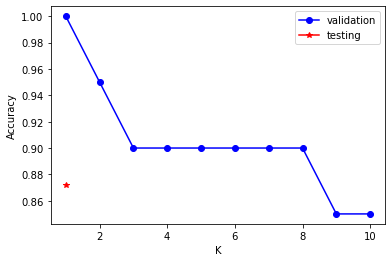

In [100]:
model_choices = []
valid_acc = []

n_valid = hep_y_va.shape[0]

for k in range(1,11):
  knn = KNN()
  hep_y_va_prob, _ = knn.fit(hep_x_train, hep_y_train - 1, K=k).predict(hep_x_va)
  hep_y_va_pred = np.argmax(hep_y_va_prob, axis = -1)
  hep_y_va_pred += 1
  accuracy = evaluate_acc(hep_y_va.values.flatten(), hep_y_va_pred)
  # print(accuracy)
  model_choices.append(k)
  valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN()

hep_y_test_prob, _ = knn.fit(hep_x_train, hep_y_train - 1, K=best_valid_K).predict(hep_x_test)
hep_y_test_pred = np.argmax(hep_y_test_prob, axis = -1)
hep_y_test_pred += 1
test_accuracy = evaluate_acc(hep_y_test.values.flatten(), hep_y_test_pred)
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

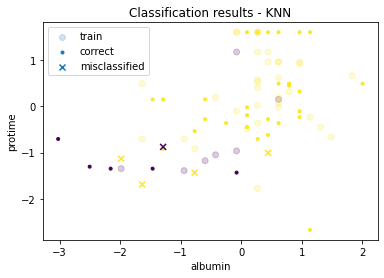

In [101]:
correct = hep_y_test_pred == hep_y_test.values.flatten()
incorrect = np.logical_not(correct)

plt.scatter(hep_x_train.iloc[:,0], hep_x_train.iloc[:,1], c=hep_y_train.iloc[:,0], marker='o', alpha=.2, label='train')
plt.scatter(hep_x_test.iloc[correct,0], hep_x_test.iloc[correct,1], marker='.', c=hep_y_test_pred[correct], label='correct')
plt.scatter(hep_x_test.iloc[incorrect,0], hep_x_test.iloc[incorrect,1], marker='x', c=hep_y_test.values[incorrect], label='misclassified')
plt.ylabel('protime')
plt.xlabel('albumin')
plt.title('Classification results - KNN')
plt.legend()

Decision boundary:

Text(0.5, 1.0, 'K = 1')

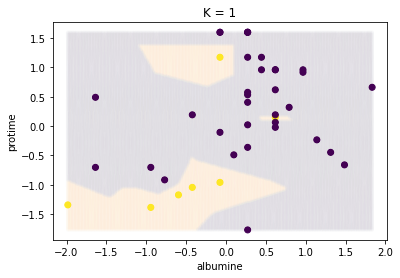

In [102]:
x0v = np.linspace(np.min(hep_x_train.iloc[:,0]), np.max(hep_x_train.iloc[:,0]), 200)
x1v = np.linspace(np.min(hep_x_train.iloc[:,1]), np.max(hep_x_train.iloc[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
x_all = pd.DataFrame(x_all)

model = KNN()
y_prob_all, _ = model.fit(hep_x_train, hep_y_train - 1, K=best_valid_K).predict(x_all)
y_train_prob = np.zeros((hep_y_train.shape[0], model.C))
y_train_prob[np.arange(hep_y_train.shape[0]), hep_y_train.iloc[:,0]-1] = 1
y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1  
plt.scatter(hep_x_train.iloc[:,0], hep_x_train.iloc[:,1], c=y_train_prob[:,0], marker='o', alpha=1)
plt.scatter(x_all.iloc[:,0], x_all.iloc[:,1], c=y_pred_all[:,0], marker='.', alpha=.01)
plt.ylabel('protime')
plt.xlabel('albumine')
plt.title('K = ' + str(best_valid_K))

We want to get the accuracy using the manhattan distance

In [103]:
def manhattan(x1, x2):
  return np.absolute(x1 - x2).sum(axis=2) #axis must be 2 bc of broadcasting
model_choices = []
valid_acc = []

n_valid = hep_y_va.shape[0]

for k in range(1,11):
  knn = KNN(dist_fn=manhattan)
  hep_y_va_prob, _ = knn.fit(hep_x_train, hep_y_train - 1, K=k).predict(hep_x_va)
  hep_y_va_pred = np.argmax(hep_y_va_prob, axis = -1)
  hep_y_va_pred += 1
  accuracy = evaluate_acc(hep_y_va.values.flatten(), hep_y_va_pred)
  # print(accuracy)
  model_choices.append(k)
  valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN()

hep_y_test_prob, _ = knn.fit(hep_x_train, hep_y_train - 1, K=best_valid_K).predict(hep_x_test)
hep_y_test_pred = np.argmax(hep_y_test_prob, axis = -1)
hep_y_test_pred += 1
test_accuracy = evaluate_acc(hep_y_test.values.flatten(), hep_y_test_pred)
print(f'best K = {best_valid_K}, test accuracy using manhattan distance = {test_accuracy}')

best K = 1, test accuracy using manhattan distance = 0.8717948717948718


# Messidor dataset

We first load the messidor dataset and assigning columns names to each column.

In [104]:
column_names = ['quality', 'pre-screening', 'MA, 0.5', 'MA, 0.6', 'MA, 0.7', 'MA, 0.8', 'MA, 0.9, ', 'MA, 1', 'exudates, 0.5', 'exudates, 0.57', 'exudates, 0.64', 'exudates, 0.71', 'exudates, 0.79', 'exudates, 0.86', 'exudates, 0.93', 'exudates, 1', 'distance', 'diameter', 'AM/FM classification', 'class']
messidor = pd.read_csv('messidor_features.csv', header=None, names=column_names, skiprows=24)
messidor

,quality,pre-screening,"MA, 0.5","MA, 0.6","MA, 0.7","MA, 0.8","MA, 0.9,","MA, 1","exudates, 0.5","exudates, 0.57","exudates, 0.64","exudates, 0.71","exudates, 0.79","exudates, 0.86","exudates, 0.93","exudates, 1",distance,diameter,AM/FM classification,class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1,1,34,34,34,33,31,24,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,1,49,49,49,49,45,37,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1148,1,0,49,48,48,45,43,33,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0,0
1149,1,1,39,36,29,23,13,7,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [105]:
messidor.describe()

,quality,pre-screening,"MA, 0.5","MA, 0.6","MA, 0.7","MA, 0.8","MA, 0.9,","MA, 1","exudates, 0.5","exudates, 0.57","exudates, 0.64","exudates, 0.71","exudates, 0.79","exudates, 0.86","exudates, 0.93","exudates, 1",distance,diameter,AM/FM classification,class
count,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000
mean,0.996525,0.918332,38.428323,36.909644,35.140747,32.297133,28.747176,21.151173,64.096674,23.088012,8.704610,1.836489,0.560738,0.212290,0.085674,0.037225,0.523212,0.108431,0.336229,0.530843
std,0.058874,0.273977,25.620913,24.105612,22.805400,21.114767,19.509227,15.101560,58.485289,21.602696,11.567589,3.923224,2.484111,1.057126,0.398717,0.178959,0.028055,0.017945,0.472624,0.499265
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.349274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367762,0.057906,0.000000,0.000000
25%,1.000000,1.000000,16.000000,16.000000,15.000000,14.000000,11.000000,8.000000,22.271597,7.939315,1.249050,0.081554,0.000000,0.000000,0.000000,0.000000,0.502855,0.095799,0.000000,0.000000
50%,1.000000,1.000000,35.000000,35.000000,32.000000,29.000000,25.000000,18.000000,44.249119,17.038020,4.423472,0.484829,0.022248,0.001554,0.000000,0.000000,0.523308,0.106623,0.000000,1.000000
75%,1.000000,1.000000,55.000000,53.000000,51.000000,48.000000,43.000000,32.000000,87.804112,31.305692,11.766880,1.921648,0.191953,0.038450,0.004832,0.003851,0.543670,0.119591,1.000000,1.000000
max,1.000000,1.000000,151.000000,132.000000,120.000000,105.000000,97.000000,89.000000,403.939108,167.131427,106.070092,59.766121,51.423208,20.098605,5.937799,3.086753,0.592217,0.219199,1.000000,1.000000


In [106]:
messidor.corr()

,quality,pre-screening,"MA, 0.5","MA, 0.6","MA, 0.7","MA, 0.8","MA, 0.9,","MA, 1","exudates, 0.5","exudates, 0.57","exudates, 0.64","exudates, 0.71","exudates, 0.79","exudates, 0.86","exudates, 0.93","exudates, 1",distance,diameter,AM/FM classification,class
quality,1.000000,-0.017611,0.035576,0.035929,0.033395,0.036506,0.034817,0.031889,0.063597,0.063061,0.044449,0.027656,0.013336,0.011864,0.012695,0.012289,-0.021943,-0.067325,-0.051723,0.062816
pre-screening,-0.017611,1.000000,0.053300,0.054839,0.053056,0.059063,0.060557,0.060152,0.062930,0.052453,0.053534,0.041607,0.015900,0.018950,0.023268,0.023861,0.004751,-0.079577,0.010782,-0.076925
"MA, 0.5",0.035576,0.053300,1.000000,0.996177,0.985730,0.963149,0.925274,0.859620,-0.229653,-0.103047,-0.044650,0.103035,0.134464,0.142917,0.196550,0.208422,0.000001,0.033992,-0.344317,0.292603
"MA, 0.6",0.035929,0.054839,0.996177,1.000000,0.994221,0.977030,0.944504,0.883511,-0.244704,-0.115253,-0.058364,0.086486,0.117895,0.124198,0.172633,0.185645,0.001953,0.034714,-0.360716,0.266338
"MA, 0.7",0.033395,0.053056,0.985730,0.994221,1.000000,0.991821,0.968676,0.916198,-0.283188,-0.139111,-0.086595,0.057769,0.094513,0.098859,0.140774,0.156441,0.000387,0.030396,-0.389384,0.234691
"MA, 0.8",0.036506,0.059063,0.963149,0.977030,0.991821,1.000000,0.988294,0.947860,-0.309950,-0.160011,-0.109946,0.029768,0.067477,0.069797,0.102638,0.119405,0.001520,0.016854,-0.411806,0.197511
"MA, 0.9,",0.034817,0.060557,0.925274,0.944504,0.968676,0.988294,1.000000,0.974577,-0.349811,-0.197279,-0.152578,-0.020469,0.022265,0.024959,0.050579,0.070735,-0.001725,0.010961,-0.437036,0.161631
"MA, 1",0.031889,0.060152,0.859620,0.883511,0.916198,0.947860,0.974577,1.000000,-0.375506,-0.223681,-0.181197,-0.058153,-0.012400,-0.012175,0.006868,0.031520,-0.002557,-0.011607,-0.435127,0.127861
"exudates, 0.5",0.063597,0.062930,-0.229653,-0.244704,-0.283188,-0.309950,-0.349811,-0.375506,1.000000,0.767091,0.763409,0.486606,0.163915,0.132227,0.114722,0.084682,-0.086155,-0.086474,0.390304,0.058015
"exudates, 0.57",0.063061,0.052453,-0.103047,-0.115253,-0.139111,-0.160011,-0.197279,-0.223681,0.767091,1.000000,0.919589,0.624537,0.257159,0.216127,0.181431,0.139196,-0.128990,-0.090721,0.291554,0.000479


Notable correlations:
*   Exudates 1-3/AM-FM classification
*   MA, 0.5/Class
*   MA, 0.6/Class
*   MA, 0.7/Class

Since the features chosen are on the same scale, there is no need to standardize the data. 

We want to run the decision tree algorithm first on the set

In [107]:
#Randomize the data
messidor = messidor.sample(frac=1, random_state=1).reset_index(drop=True)

#Divide into training and testing sets
N = messidor.shape[0]
messidor_X = messidor[['MA, 0.5', 'MA, 0.7']] #we chose the two features with the highest correlation
messidor_y = messidor['class'].replace([1],2) #We make it so 
messidor_y = messidor_y.replace([0],1)

messidor_y_train = messidor_y[:int(N/2)]
messidor_X_train = messidor_X[:int(N/2)]
messidor_y_test = messidor_y[int(N/2):]
messidor_X_test = messidor_X[int(N/2):]

#Splitting trainsing into 50% training and 50% validation
M = messidor_X_train.shape[0]

messidor_X_train_tr = messidor_X_train[int(M/2):]
messidor_y_train_tr = messidor_y_train[int(M/2):]

messidor_X_train_va = messidor_X_train[:int(M/2)]
messidor_y_train_va = messidor_y_train[:int(M/2)]

#Best depth
model_choices = []
train_acc = []
valid_acc = []

#Changing from panda dataframes to numpy arrays
messidor_X = messidor_X.to_numpy()
messidor_y = messidor_y.to_numpy()
messidor_X_train = messidor_X_train.to_numpy()
messidor_y_train = messidor_y_train.to_numpy()
messidor_X_test = messidor_X_test.to_numpy()
messidor_y_test = messidor_y_test.to_numpy()

(num_instances, num_features), num_classes = messidor_X.shape, np.max(messidor_y)+1 
#contrarily to the other dataset, the labels are 1 and 0 instead of 1 and 2, so the max is seen as 1 even though there are clearly 2 classes.
#To fix this problem, we can either change every 1 into a 2, and every 0 into a 1 in the label column, or we can simply add 2 instead of adding 1.

for k in range(1, 11):
    messidor_dt = DecisionTree(cost_fn = cost_entropy)
    
    messidor_y_train_tr_prob = messidor_dt.fit(messidor_X_train_tr, messidor_y_train_tr, k).predict(messidor_X_train_tr)
    messidor_y_train_tr_pred = np.argmax(messidor_y_train_tr_prob, axis=-1)
    acc_tr = evaluate_acc(messidor_y_train_tr_pred, messidor_y_train_tr)
    
    messidor_y_train_va_prob = messidor_dt.fit(messidor_X_train_tr, messidor_y_train_tr, k).predict(messidor_X_train_va)
    messidor_y_train_va_pred = np.argmax(messidor_y_train_va_prob, axis=-1)
    acc_va = evaluate_acc(messidor_y_train_va_pred, messidor_y_train_va)
    
    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

#Find best k 
best_depth = model_choices[valid_acc.index(max(valid_acc))]   
messidor_dt = DecisionTree(cost_fn = cost_entropy)
messidor_y_test_prob = messidor_dt.fit(messidor_X_train, messidor_y_train, best_depth).predict(messidor_X_test)
messidor_y_test_pred = np.argmax(messidor_y_test_prob, axis=-1)
test_accuracy = evaluate_acc(messidor_y_test_pred, messidor_y_test)
print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')


best depth = 9, test accuracy = 0.6666666666666666


We want to be able to visualize the effects of the depth on the acurracy of the prediction of the three sets using a plot:

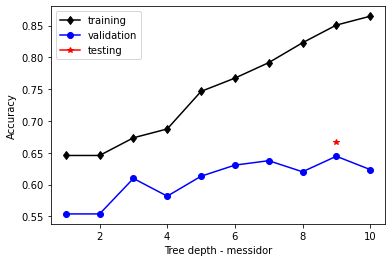

In [108]:
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth - messidor")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Now we predict on the test data

accuracy is 66.7.


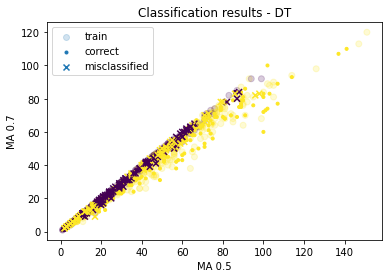

In [109]:
tree = DecisionTree(cost_fn = cost_entropy)
probs_test = tree.fit(messidor_X_train, messidor_y_train, best_depth).predict(messidor_X_test)
y_pred = np.argmax(probs_test,1)
accuracy = evaluate_acc(y_pred, messidor_y_test)
print(f'accuracy is {accuracy*100:.1f}.')

#visualization
correct = messidor_y_test == y_pred 
incorrect = np.logical_not(correct)
plt.scatter(messidor_X_train[:,0], messidor_X_train[:,1], c=messidor_y_train, marker='o', alpha=.2, label='train')
plt.scatter(messidor_X_test[correct,0], messidor_X_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(messidor_X_test[incorrect,0], messidor_X_test[incorrect,1], marker='x', c=messidor_y_test[incorrect], label='misclassified')
plt.title('Classification results - DT')
plt.ylabel('MA 0.7')
plt.xlabel('MA 0.5')
plt.legend()
plt.show()   

Decision boundary:

Text(0.5, 1.0, 'Depth = 9')

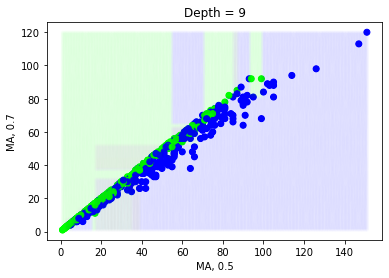

In [110]:
x0v = np.linspace(np.min(messidor_X[:,0]), np.max(messidor_X[:,0]), 200)
x1v = np.linspace(np.min(messidor_X[:,1]), np.max(messidor_X[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(cost_fn = cost_entropy)
y_train_prob = np.zeros((messidor_y_train.shape[0], num_classes))
y_train_prob[np.arange(messidor_y_train.shape[0]), messidor_y_train] = 1
y_prob_all = model.fit(messidor_X_train, messidor_y_train, best_depth).predict(x_all)
plt.scatter(messidor_X_train[:,0], messidor_X_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('MA, 0.7')
plt.xlabel('MA, 0.5')
plt.title('Depth = ' + str(best_depth))

We want to see the effects of changing the cost function on the accuracy.

In [111]:
gini_index_tree = DecisionTree(cost_fn = cost_gini_index)
probs_test = gini_index_tree.fit(messidor_X_train, messidor_y_train, best_depth).predict(messidor_X_test)
y_pred = np.argmax(probs_test,1)
accuracy_g = evaluate_acc(y_pred, messidor_y_test)
print(f'accuracy using gini index is {accuracy_g*100:.1f}.')

misclassification_tree = DecisionTree(cost_fn = cost_misclassification)
probs_test = misclassification_tree.fit(messidor_X_train, messidor_y_train, best_depth).predict(messidor_X_test)
y_pred = np.argmax(probs_test,1)
accuracy_e = evaluate_acc(y_pred, messidor_y_test)
print(f'accuracy using misclassification cost is {accuracy_e*100:.1f}.')

accuracy using gini index is 65.5.
accuracy using misclassification cost is 66.7.


We want to visualize the tree using sklearn:

In [112]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
sktree = DecisionTreeClassifier(max_depth=best_depth, random_state=(0))
sktree.fit(messidor_X_train, messidor_y_train)
sktree.predict(messidor_X_test)
pred = sktree.predict(messidor_X_test)

fn = ['MA, 0.5', 'MA, 0.7']
cn = ['Sick', "Healthy"]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=900)

tree.plot_tree(sktree, feature_names = fn, class_names=cn, filled = True)
fig.savefig('imagename.png')

Similar to the work done on the hepatitis dataset, we need to reload the data such that the KNN algorithm runs smoothly. 

In [113]:
#Randomize the data
messidor_df = messidor
N = messidor_df.shape[0]
messidor_df_x = messidor_df[['MA, 0.5', 'MA, 0.7']]
messidor_y_train = messidor_df[['class']][:int(N/2)]
messidor_x_train = messidor_df_x[:int(N/2)]
messidor_y_test = messidor_df[['class']][int(N/2):]
messidor_x_test = messidor_df_x[int(N/2):]

M = messidor_x_test.shape[0]
messidor_x_tr, messidor_y_tr = messidor_x_train[int(M/2):], messidor_y_train[int(M/2):]
messidor_x_va, messidor_y_va = messidor_x_train[:int(M/2)], messidor_y_train[:int(M/2)]

best K = 9, test accuracy = 0.6909722222222222


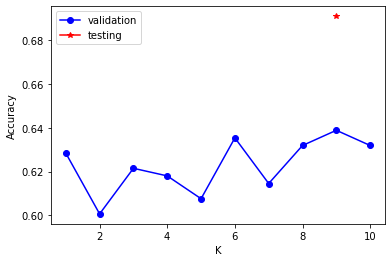

In [114]:
model_choices = []
valid_acc = []

n_valid = messidor_y_va.shape[0]

for k in range(1,11):
  knn = KNN()
  messidor_y_va_prob, _ = knn.fit(messidor_x_tr, messidor_y_tr, K=k).predict(messidor_x_va)
  messidor_y_va_pred = np.argmax(messidor_y_va_prob, axis = -1)
  accuracy = evaluate_acc(messidor_y_va.values.flatten(), messidor_y_va_pred)
  model_choices.append(k)
  valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN()

messidor_y_test_prob, _ = knn.fit(messidor_x_tr, messidor_y_tr, K=best_valid_K).predict(messidor_x_test)
messidor_y_test_pred = np.argmax(messidor_y_test_prob, axis = -1)
test_accuracy = evaluate_acc(messidor_y_test.values.flatten(), messidor_y_test_pred)
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

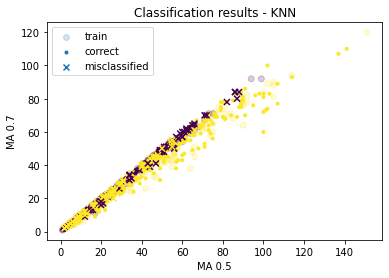

In [115]:
correct = messidor_y_test_pred == messidor_y_test.values.flatten()
incorrect = np.logical_not(correct)

plt.scatter(messidor_x_tr.iloc[:,0], messidor_x_tr.iloc[:,1], c=messidor_y_tr.iloc[:,0], marker='o', alpha=.2, label='train')
plt.scatter(messidor_x_test.iloc[correct,0], messidor_x_test.iloc[correct,1], marker='.', c=messidor_y_test_pred[correct], label='correct')
plt.scatter(messidor_x_test.iloc[incorrect,0], messidor_x_test.iloc[incorrect,1], marker='x', c=messidor_y_test.values[incorrect], label='misclassified')
plt.ylabel('MA 0.7')
plt.xlabel('MA 0.5')
plt.title('Classification results - KNN')
plt.legend()

Decision boundary:

Text(0.5, 1.0, 'K = 9')

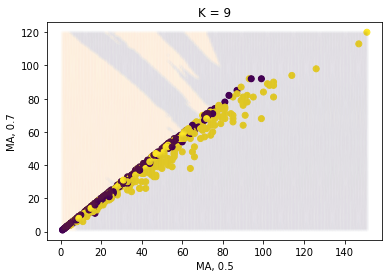

In [116]:
x0v = np.linspace(np.min(messidor_x_train.iloc[:,0]), np.max(messidor_x_train.iloc[:,0]), 200)
x1v = np.linspace(np.min(messidor_x_train.iloc[:,1]), np.max(messidor_x_train.iloc[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
x_all = pd.DataFrame(x_all)


model = KNN()
y_prob_all, _ = model.fit(messidor_x_train, messidor_y_train, K=best_valid_K).predict(x_all)
y_train_prob = np.zeros((messidor_y_train.shape[0], model.C))
y_train_prob[np.arange(messidor_y_train.shape[0]), messidor_y_train.iloc[:,0]-1] = 1
y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1  
plt.scatter(messidor_x_train.iloc[:,0], messidor_x_train.iloc[:,1], c=y_train_prob[:,0], marker='o', alpha=1)
plt.scatter(x_all.iloc[:,0], x_all.iloc[:,1], c=y_pred_all[:,0], marker='.', alpha=.01)
plt.ylabel('MA, 0.7')
plt.xlabel('MA, 0.5')
plt.title('K = ' + str(best_valid_K))

We want to get the accuracy on the test set using the manhattan distance

In [117]:
model_choices = []
valid_acc = []

n_valid = messidor_y_va.shape[0]

for k in range(1,11):
  knn = KNN(dist_fn=manhattan)
  messidor_y_va_prob, _ = knn.fit(messidor_x_tr, messidor_y_tr, K=k).predict(messidor_x_va)
  messidor_y_va_pred = np.argmax(messidor_y_va_prob, axis = -1)
  accuracy = evaluate_acc(messidor_y_va.values.flatten(), messidor_y_va_pred)
  # print(accuracy)
  model_choices.append(k)
  valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN()

messidor_y_test_prob, _ = knn.fit(messidor_x_tr, messidor_y_tr, K=best_valid_K).predict(messidor_x_test)
messidor_y_test_pred = np.argmax(messidor_y_test_prob, axis = -1)
test_accuracy = evaluate_acc(messidor_y_test.values.flatten(), messidor_y_test_pred)
print(f'best K = {best_valid_K}, test accuracy using manhattan distance = {test_accuracy}')

best K = 9, test accuracy using manhattan distance = 0.6909722222222222
